### imports

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score

In [14]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

### load predictions

In [4]:
predictions = pd.read_csv("embryoAI_datasets/embryoAI_predictions.csv")
predictions["prediction"] = predictions.prediction.progress_apply(lambda x: x.strip("[[]]").split())
predictions["prediction"] = predictions.prediction.progress_apply(lambda x : [float(a) for a in x])
predictions[:4]

100%|███████████████████████████████| 137682/137682 [00:00<00:00, 357050.88it/s]


,case,frame,phase,path,flag,prediction,predicted_phase
0,DS61-1,19,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN19.jpeg,growing,"[0.00013657552, 1.6470891e-07, 1.1463476e-07, ...",tPNa
1,DS61-1,20,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN20.jpeg,growing,"[6.9838177e-05, 1.411306e-07, 5.1814305e-07, 3...",tPB2
2,DS61-1,29,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN29.jpeg,growing,"[8.6491083e-05, 1.6546151e-07, 5.0405244e-08, ...",tPB2
3,DS61-1,30,tPNa,DS61-1/D2012.01.27_S0364_I132_WELL1_RUN30.jpeg,growing,"[8.4943909e-05, 1.0639483e-07, 3.0971755e-08, ...",tPNa


In [5]:
# assume y_true and y_pred are your true and predicted labels, respectively
y_true = predictions.phase.values
y_pred = predictions.predicted_phase.values
y_pred_proba = np.array([y for y in predictions.prediction.values])
n_classes = len(set(y_true))
categories = {0: 't2',
 1: 't3',
 2: 't4',
 3: 't5',
 4: 't6',
 5: 't7',
 6: 't8',
 7: 't9+',
 8: 'tB',
 9: 'tEB',
 10: 'tHB',
 11: 'tM',
 12: 'tPB2',
 13: 'tPNa',
 14: 'tPNf',
 15: 'tSB'}
y_true_one_hot = pd.get_dummies(predictions.phase.map({v:k for k,v in categories.items()})).values

### confusion matrix

<Axes: >

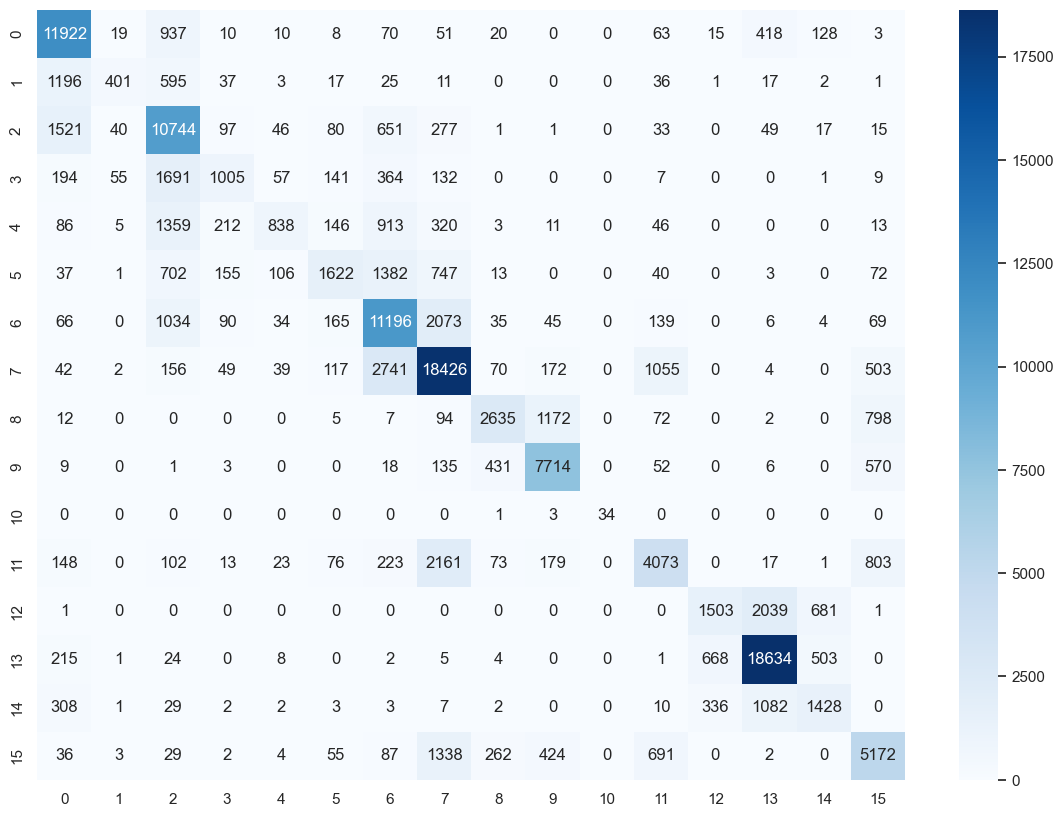

In [12]:
# calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.set(rc={'figure.figsize':(14, 10)})
cm_plot = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
cm_plot

### evaluations

In [13]:
# calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# calculate precision
precision = precision_score(y_true, y_pred, average="weighted")
print("Precision:", precision)

# calculate recall
sensitivity = recall_score(y_true, y_pred, average="weighted")
print("Sensitivity:", sensitivity)

# calculate specificity
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("Specificity:", specificity)

# calculate Cohen's kappa
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

Accuracy: 0.7070423148995512
Precision: 0.7037494824280902
Sensitivity: 0.7070423148995512
Specificity: 0.9984088434804456
Cohen's Kappa: 0.6719372344187282


### precision recall curve

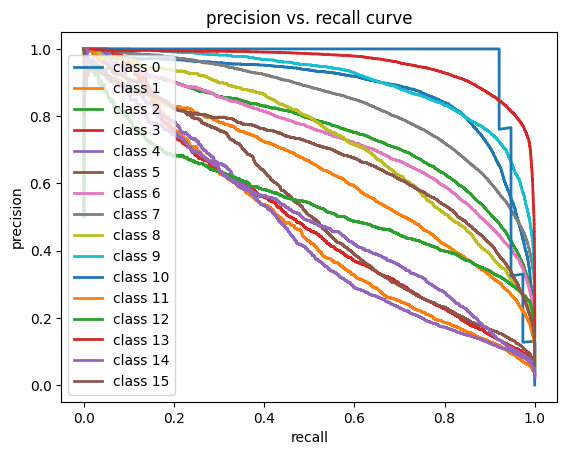

In [8]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_one_hot[:, i],
                                                        y_pred_proba[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

### multi-class roc auc scores

In [27]:
roc_auc_score(y_true_one_hot, y_pred_proba, average="macro")

0.9686456000467454

ROC AUC score: 0.9686456000467454


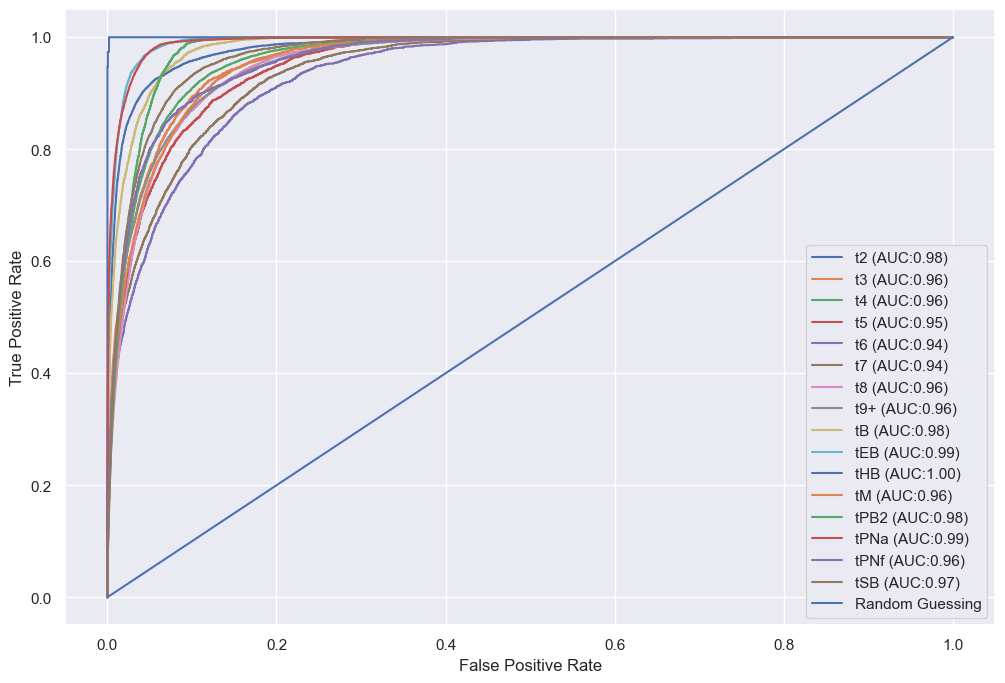

In [33]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_true_one_hot, y_pred_proba, average="macro"):
    for (idx, c_label) in enumerate(categories.values()):
        fpr, tpr, thresholds = roc_curve(y_true_one_hot[:,idx], y_pred_proba[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_true_one_hot, y_pred_proba, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true_one_hot, y_pred_proba))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()